[ISSUE #56](https://github.com/okfn-brasil/censo-querido-diario/issues/56)

Esta análise integra a seção destinada aos aspectos institucionais.
Aqui deverá constar um levantamento de quantos municípios possuem mais de uma fonte de publicação de diários oficiais e quantos possuem apenas uma fonte.

Conjunto de dados com cidades com mais de 100mil habitantes

IDEIAS PARA ANÁLISE:

1. Quantos municípios não possuem nenhuma fonte de publicação eletrônica?

2. Em qual região predomina a falta de publicação eletrônica?

3. Quais dos municípios possuem apenas 1 fonte de publicação oficial?

4. Quais os municípios possuem mais de 1 fonte de publicação?

5. Esse municípios com várias fontes de publicação, predominam em alguma região do país?

6. Há alguma correlação entre quantidade de fontes por município e antiguidade?

7. As capitais costumam ter mais de uma fonte de publicação? Quantas?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
municipios = pd.read_csv("/content/base_mapeamento.csv")

In [3]:
municipios.head()

,municipio,IBGE,IBGE7,UF,regiao,populacao_2020,eh_capital,fonte_1,fonte_2,fonte_3,fonte_4,is_online,data_inicial,tipo_arquivo,validacao,navegacao,observacoes
0,Abaetetuba (PA),150010,1500107,PA,Região Norte,159080,False,http://www.diariomunicipal.com.br/famep/pesqui...,None,None,None,1,2016-06-30,HTML,True,None,NaN
1,Abreu e Lima (PE),260005,2600054,PE,Região Nordeste,100346,False,http://www.diariomunicipal.com.br/amupe/,None,None,None,1,None,PDF texto,True,None,O Diário Oficial do município de Abreu e Lima ...
2,Alagoinhas (BA),290070,2900702,BA,Região Nordeste,152327,False,https://doem.org.br/ba/alagoinhas,None,None,None,1,2015-01-28,PDF texto,True,None,None
3,Almirante Tamandaré (PR),410040,4100400,PR,Região Sul,120041,False,http://www.diariomunicipal.com.br/amp/pesquisa...,None,None,None,1,2014-01-08,HTML,True,None,NaN
4,Altamira (PA),150060,1500602,PA,Região Norte,115969,False,http://altamira.pa.gov.br/site/download-catego...,None,None,None,1,2013-05-11,PDF imagem,True,None,NaN


## Pré-processamento

In [4]:
municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   municipio       326 non-null    object
 1   IBGE            326 non-null    int64 
 2   IBGE7           326 non-null    int64 
 3   UF              326 non-null    object
 4   regiao          326 non-null    object
 5   populacao_2020  326 non-null    int64 
 6   eh_capital      326 non-null    bool  
 7   fonte_1         326 non-null    object
 8   fonte_2         326 non-null    object
 9   fonte_3         326 non-null    object
 10  fonte_4         326 non-null    object
 11  is_online       326 non-null    int64 
 12  data_inicial    326 non-null    object
 13  tipo_arquivo    326 non-null    object
 14  validacao       326 non-null    bool  
 15  navegacao       326 non-null    object
 16  observacoes     133 non-null    object
dtypes: bool(2), int64(4), object(11)
memory usage: 39.0+ K

Algumas colunas, como as referentes a fontes e data, tem datos do tipo strings, e possuem strings `"None"`, como pode ser visto. O primeiro processamento que podemos fazer é substituir essas strings pelo valor `None` de fato.


In [5]:
municipios[['fonte_1', 'fonte_2', 'fonte_3', 'fonte_4', 'data_inicial']] = municipios[
    ['fonte_1', 'fonte_2', 'fonte_3', 'fonte_4', 'data_inicial']
].replace({'None': None})

E como segundo processamento, podemos concatenar todos os valores das colunas de fonte em uma única coluna. Assim, visamos facilitar o trabalho da análise já que lidaremos apenas com uma coluna única.

Usaremos o divisor `" | "` para separar as urls, já que é uma combinação de caracteres difícil de encontrar em urls e fácil de visualizar "no olho".

In [6]:
def concatenate_valid_fontes(row):
    valid_fontes = []

    for column, value in row.items():
        if value is not None:
            valid_fontes.append(value)
    
    return ' | '.join(valid_fontes)

municipios['fontes'] = municipios[['fonte_1', 'fonte_2', 'fonte_3', 'fonte_4']].apply(concatenate_valid_fontes, axis=1)
municipios['fontes'].head(20).to_list()

['http://www.diariomunicipal.com.br/famep/pesquisar?busca_avancada%5B__paper%5D=1&busca_avancada%5BentidadeUsuaria%5D=25873&busca_avancada%5Bnome_orgao%5D=&busca_avancada%5Btitulo%5D=&busca_avancada%5Bt',
 'http://www.diariomunicipal.com.br/amupe/',
 'https://doem.org.br/ba/alagoinhas',
 'http://www.diariomunicipal.com.br/amp/pesquisar?busca_avancada%5BentidadeUsuaria%5D=10741',
 'http://altamira.pa.gov.br/site/download-category/diario-oficial/',
 'http://www.diariomunicipal.com.br/famurs/pesquisar',
 'https://diariooficial.americana.sp.gov.br/diario-oficial-index.php',
 'http://www.ananindeua.pa.gov.br/diario/',
 'http://angra.rj.gov.br/boletim-oficial.asp?indexsigla=imp',
 'http://www.diario.anapolis.go.gov.br:8124/dowebans/page/diarioOficial.jsf',
 'https://doe.aparecida.go.gov.br',
 'http://sys.apucarana.pr.gov.br/apucarana-pr/FWLocal/diario_oficial/',
 'http://sga.aracaju.se.gov.br:5011/legislacao/faces/diario_form_pesq.jsp',
 'https://diariomunicipal.es.gov.br/?r=site/index&q=+en

Também podemos adicionar uma nova coluna com a quantidade de fontes em cada cidade.

In [7]:
municipios['fontes_qtd'] = municipios['fontes'].str.count(' \| ') + 1

A " | " é utilizada para separar os sites quando o município possui mais de uma fonte de informação, ou seja, a barra será utilizada sempre após o primeiro site, se houver mais de um. Com isso, conseguimos contar quantos sites extras o município possui para publicação. Então, somamos 1 ao número total de barras, para simbolizar a primeira fonte de informação que não seria levada em conta.


In [8]:
print([1, municipios.loc[12][['municipio', 'fontes']].to_list()])
print([2, municipios.loc[50][['municipio', 'fontes', ]].to_list()])
print([3, municipios.loc[91][['municipio', 'fontes', ]].to_list()])

[1, ['Aracaju (SE)', 'http://sga.aracaju.se.gov.br:5011/legislacao/faces/diario_form_pesq.jsp']]
[2, ['Brasília (DF)', 'http://www.buriti.df.gov.br/ftp/ | http://www.dodf.df.gov.br/']]
[3, ['Cuiabá (MT)', 'http://www.diariomunicipal.com.br/amm-mt/pesquisar | https://diariomunicipal.org/mt/amm/publicacoes/?e=432 | https://diariooficial.cuiaba.mt.gov.br/']]


Pelo pré-processamento que fizemos até agora, as colunas 'fonte_1', 'fonte_2', 'fonte_3', 'fonte_4' podem ser descartadas, pois seus dados estão na coluna 'fontes'.

In [9]:
municipios = municipios.drop(columns=['fonte_1', 'fonte_2', 'fonte_3', 'fonte_4'])
municipios.head()

,municipio,IBGE,IBGE7,UF,regiao,populacao_2020,eh_capital,is_online,data_inicial,tipo_arquivo,validacao,navegacao,observacoes,fontes,fontes_qtd
0,Abaetetuba (PA),150010,1500107,PA,Região Norte,159080,False,1,2016-06-30,HTML,True,None,NaN,http://www.diariomunicipal.com.br/famep/pesqui...,1
1,Abreu e Lima (PE),260005,2600054,PE,Região Nordeste,100346,False,1,None,PDF texto,True,None,O Diário Oficial do município de Abreu e Lima ...,http://www.diariomunicipal.com.br/amupe/,1
2,Alagoinhas (BA),290070,2900702,BA,Região Nordeste,152327,False,1,2015-01-28,PDF texto,True,None,None,https://doem.org.br/ba/alagoinhas,1
3,Almirante Tamandaré (PR),410040,4100400,PR,Região Sul,120041,False,1,2014-01-08,HTML,True,None,NaN,http://www.diariomunicipal.com.br/amp/pesquisa...,1
4,Altamira (PA),150060,1500602,PA,Região Norte,115969,False,1,2013-05-11,PDF imagem,True,None,NaN,http://altamira.pa.gov.br/site/download-catego...,1


# ANÁLISE

## 1. Quantos municípios não possuem nenhuma fonte de publicação eletrônica?

In [10]:
municipios['is_online'].unique()

array([1, 3])

Vemos que existem apenas casos onde o site do diário está disponível online e casos sem confirmação.

Vamos explorar um pouco esses dois cenários.

In [11]:
municipios_sem_confirmacao = municipios[municipios['is_online'] == 3]
municipios_sem_confirmacao

,municipio,IBGE,IBGE7,UF,regiao,populacao_2020,eh_capital,is_online,data_inicial,tipo_arquivo,validacao,navegacao,observacoes,fontes,fontes_qtd
242,Rio Grande (RS),431560,4315602,RS,Região Sul,211965,False,3,None,None,True,None,Não encontrado veículo de publicação oficial n...,https://www.in.gov.br/consulta/-/buscar/dou?q=...,1
315,Viamão (RS),432300,4323002,RS,Região Sul,256302,False,3,None,None,True,None,Endereço existe (https://www.viamao.rs.gov.br/...,https://www.in.gov.br/consulta/-/buscar/dou?q=...,1


In [12]:
municipios_sem_confirmacao['fontes'].unique()

array(['https://www.in.gov.br/consulta/-/buscar/dou?q=%22Munic%C3%ADpio+de+Rio+Grande%22&orgPrin=Prefeituras&orgSub=Estado+do+Rio+Grande+do+Sul',
       'https://www.in.gov.br/consulta/-/buscar/dou?q=%22Munic%C3%ADpio+de+Viam%C3%A3o%22&orgPrin=Prefeituras&orgSub=Estado+do+Rio+Grande+do+Sul'],
      dtype=object)

Vimos que existem apenas dois municípios sem confirmação de diário oficial online.

Agora, vamos visualizar a frequência de ocorrência de cada um dos cenários.

In [13]:
is_online = [1, 2, 3]
frequencia = municipios['is_online'].value_counts().to_list()
print(frequencia)

[324, 2]


Como não é mostrado nenhum valor para o cenário 2, vamos inserir ele manualmente para complementar a visualização.



In [14]:
frequencia.insert(1, 0)
print(frequencia)

[324, 0, 2]


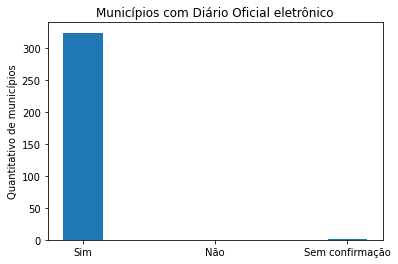

In [15]:
plt.bar(is_online, frequencia, width=0.3)
plt.title('Municípios com Diário Oficial eletrônico')
plt.xticks(is_online, ('Sim', 'Não', 'Sem confirmação'))
plt.ylabel('Quantitativo de municípios')

plt.show()

Vamos exportar os dados para .csv, o que possibilitará gerar visualização fora do notebook.

In [16]:
municipio_has_diario = pd.DataFrame(
    data={
        'is_online': is_online,
        'is_online_label': ['Sim', 'Não', 'Sem confirmação'],
        'total': frequencia
    }
)
municipio_has_diario.to_csv(r'pergunta_1.csv', index=False)

### Conclusão 1

Entre todas as cidades com mais de 100mil habitantes, Rio Grande(RS) e Viamão(RS) não tiveram seus Diários Oficiais municipais localizados. No entanto, foram encontrados alguns atos oficiais publicados no Diário oficial da União entre os anos de 2018 e 2021.

-------------------

## 2. Em qual região predomina a falta de publicação eletrônica?

### Conclusão 2

Como observado na análise anterior, não foi confirmada a publicação de diários oficiais em meio eletrônico em apenas 2 cidades, ambas do Rio Grande do Sul.

---------------------


## 3. Quais os municípios possuem apenas 1 fonte de publicação oficial?

Vamos fazer um subdataframe com todos os municípios com apenas 1 fonte de publicação.

In [17]:
municipios_uma_fonte = municipios[municipios['fontes_qtd'] == 1]
municipios_uma_fonte.shape

(286, 15)

Agora vamos descobrir o quanto isto representa, em percentual, do total de municípios.

In [18]:
total_municipios_uma_fonte = municipios_uma_fonte.shape[0]
total_municipios = municipios.shape[0]
percentage_municipios_uma_fonte = round((total_municipios_uma_fonte / total_municipios * 100), 2)
percentage_municipios_uma_fonte

87.73

Podemos investigar mais utilizando outras colunas. Qual a quantidade de municípios com apenas uma fonte em cada região?

In [19]:
total_municipios_uma_fonte_regiao = municipios_uma_fonte['regiao'].value_counts()
total_municipios_uma_fonte_regiao_absolute_values = total_municipios_uma_fonte_regiao.to_list()
total_municipios_uma_fonte_regiao

Região Sudeste         135
Região Nordeste         59
Região Sul              46
Região Norte            26
Região Centro-Oeste     20
Name: regiao, dtype: int64

E esses valores representam qual porcentagem do total de municípios?

In [20]:
percentages_regioes_uma_fonte = []

for total_in_regiao in total_municipios_uma_fonte_regiao_absolute_values:
    percentage = round((total_in_regiao / total_municipios_uma_fonte *100), 1)
    percentages_regioes_uma_fonte.append(percentage)

percentages_regioes_uma_fonte

[47.2, 20.6, 16.1, 9.1, 7.0]

In [21]:
regiao_name = total_municipios_uma_fonte_regiao.index.to_list()
regiao_name

['Região Sudeste',
 'Região Nordeste',
 'Região Sul',
 'Região Norte',
 'Região Centro-Oeste']

In [22]:
municipios_uma_fonte_overview = pd.DataFrame(
    data={
        'municipios_uma_fonte': total_municipios_uma_fonte_regiao_absolute_values,
        'porcent_do_total_uma_fonte': percentages_regioes_uma_fonte
    }, 
    index=regiao_name
)
municipios_uma_fonte_overview

,municipios_uma_fonte,porcent_do_total_uma_fonte
Região Sudeste,135,47.2
Região Nordeste,59,20.6
Região Sul,46,16.1
Região Norte,26,9.1
Região Centro-Oeste,20,7.0


Para cada região, isoladamente, qual a incidência de municípios com apenas uma fonte?

In [23]:
municipios_uma_fonte_overview['total_municipios'] = municipios['regiao'].value_counts()
municipios_uma_fonte_overview

,municipios_uma_fonte,porcent_do_total_uma_fonte,total_municipios
Região Sudeste,135,47.2,154
Região Nordeste,59,20.6,64
Região Sul,46,16.1,53
Região Norte,26,9.1,31
Região Centro-Oeste,20,7.0,24


In [24]:
municipios_uma_fonte_overview['porcent_por_regiao_uma_fonte'] = round(
    (municipios_uma_fonte_overview['municipios_uma_fonte'] / municipios_uma_fonte_overview['total_municipios']) * 100,
    1
)
municipios_uma_fonte_overview

,municipios_uma_fonte,porcent_do_total_uma_fonte,total_municipios,porcent_por_regiao_uma_fonte
Região Sudeste,135,47.2,154,87.7
Região Nordeste,59,20.6,64,92.2
Região Sul,46,16.1,53,86.8
Região Norte,26,9.1,31,83.9
Região Centro-Oeste,20,7.0,24,83.3


Para ficar mais fácil de ler, podemos rearranjar as colunas.

In [25]:
municipios_uma_fonte_overview = municipios_uma_fonte_overview[
    ['total_municipios', 'municipios_uma_fonte', 'porcent_por_regiao_uma_fonte', 'porcent_do_total_uma_fonte']
]
municipios_uma_fonte_overview

,total_municipios,municipios_uma_fonte,porcent_por_regiao_uma_fonte,porcent_do_total_uma_fonte
Região Sudeste,154,135,87.7,47.2
Região Nordeste,64,59,92.2,20.6
Região Sul,53,46,86.8,16.1
Região Norte,31,26,83.9,9.1
Região Centro-Oeste,24,20,83.3,7.0


In [26]:
municipios_uma_fonte['municipio'].values

array(['Abaetetuba (PA)', 'Abreu e Lima (PE)', 'Alagoinhas (BA)',
       'Almirante Tamandaré (PR)', 'Altamira (PA)', 'Alvorada (RS)',
       'Americana (SP)', 'Ananindeua (PA)', 'Angra Dos Reis (RJ)',
       'Anápolis (GO)', 'Aparecida de Goiânia (GO)', 'Apucarana (PR)',
       'Aracaju (SE)', 'Aracruz (ES)', 'Araguari (MG)', 'Araguaína (TO)',
       'Arapiraca (AL)', 'Arapongas (PR)', 'Araras (SP)', 'Araruama (RJ)',
       'Araucária (PR)', 'Araxá (MG)', 'Araçatuba (SP)', 'Ariquemes (RO)',
       'Atibaia (SP)', 'Açailândia (MA)', 'Bacabal (MA)', 'Bagé (RS)',
       'Balneário Camboriú (SC)', 'Barbacena (MG)', 'Barcarena (PA)',
       'Barra Mansa (RJ)', 'Barra do Piraí (RJ)', 'Barreiras (BA)',
       'Barretos (SP)', 'Barueri (SP)', 'Bauru (SP)',
       'Belo Horizonte (MG)', 'Belém (PA)', 'Bento Gonçalves (RS)',
       'Betim (MG)', 'Birigui (SP)', 'Blumenau (SC)', 'Boa Vista (RR)',
       'Botucatu (SP)', 'Bragança Paulista (SP)', 'Brusque (SC)',
       'Cabo Frio (RJ)', 'Cabo de 

Vamos exportar os dados para .csv, o que possibilitará gerar visualização fora do notebook.

In [27]:
municipios_uma_fonte_overview.insert(loc=0, column='regiao_name', value=regiao_name)
municipios_uma_fonte_overview.to_csv(r'pergunta_3.csv', index=False)

### Conclusão 3

286 municípios realizam a publicação do Diário Oficial em apenas um site, isso corresponde a 87.73% do total de municípios com mais de 100 mil habitantes.

A maior parte dos municípios com apenas uma fonte de publicação encontra-se na região Sudeste (47%). No entanto, entre as regiões do país, Nordeste é a que possui maior incidência de municipios que publicam seus diário oficiais em apenas uma fonte, com 92%.

A lista completa de municípios com apenas uma fonte é a seguinte:


Abaetetuba (PA), Abreu e Lima (PE), Alagoinhas (BA), Almirante Tamandaré (PR), Altamira (PA), Alvorada (RS), Americana (SP), Ananindeua (PA), Angra Dos Reis (RJ), Anápolis (GO), Aparecida de Goiânia (GO), Apucarana (PR), Aracaju (SE), Aracruz (ES), Araguari (MG), Araguaína (TO), Arapiraca (AL), Arapongas (PR), Araras (SP), Araruama (RJ), Araucária (PR), Araxá (MG), Araçatuba (SP), Ariquemes (RO), Atibaia (SP), Açailândia (MA), Bacabal (MA), Bagé (RS), Balneário Camboriú (SC), Barbacena (MG), Barcarena (PA), Barra Mansa (RJ), Barra do Piraí (RJ), Barreiras (BA), Barretos (SP), Barueri (SP), Bauru (SP), Belo Horizonte (MG), Belém (PA), Bento Gonçalves (RS), Betim (MG), Birigui (SP), Blumenau (SC), Boa Vista (RR), Botucatu (SP), Bragança Paulista (SP), Brusque (SC), Cabo Frio (RJ), Cabo de Santo Agostinho (PE), Cachoeiro de Itapemirim (ES), Caieiras (SP), Camaragibe (PE), Camaçari (BA), Cambé (PR), Campina Grande (PB), Campinas (SP), Campo Grande (MS), Campo Largo (PR), Canoas (RS), Caraguatatuba (SP), Carapicuíba (SP), Cariacica (ES), Caruaru (PE), Cascavel (PR), Castanhal (PA), Catalão (GO), Catanduva (SP), Caucaia (CE), Caxias (MA), Caxias do Sul (RS), Chapecó (SC), Colombo (PR), Conselheiro Lafaiete (MG), Contagem (MG), Coronel Fabriciano (MG), Corumbá (MS), Cotia (SP), Crato (CE), Criciúma (SC), Cubatão (SP), Diadema (SP), Divinópolis (MG), Dourados (MS), Duque de Caxias (RJ), Embu (SP), Erechim (RS), Eunápolis (BA), Fazenda Rio Grande (PR), Feira de Santana (BA), Ferraz de Vasconcelos (SP), Florianópolis (SC), Formosa (GO), Fortaleza (CE), Foz do Iguaçu (PR), Franca (SP), Francisco Morato (SP), Franco da Rocha (SP), Garanhuns (PE), Goiânia (GO), Governador Valadares (MG), Gravataí (RS), Guarapari (ES), Guarapuava (PR), Guaratinguetá (SP), Guarujá (SP), Guarulhos (SP), Ibirité (MG), Igarassu (PE), Iguatu (CE), Ilhéus (BA), Imperatriz (MA), Indaiatuba (SP), Ipatinga (MG), Itabira (MG), Itaboraí (RJ), Itabuna (BA), Itacoatiara (AM), Itaguaí (RJ), Itaituba (PA), Itanhaém (SP), Itapecerica da Serra (SP), Itaperuna (RJ), Itapetininga (SP), Itapipoca (CE), Itaquaquecetuba (SP), Itatiba (SP), Ituiutaba (MG), Itumbiara (GO), Jaboatão Dos Guararapes (PE), Jacareí (SP), Japeri (RJ), Jaraguá do Sul (SC), Jataí (GO), Jaú (SP), Jequié (BA), Ji-paraná (RO), João Pessoa (PB), Juazeiro (BA), Juazeiro do Norte (CE), Jundiaí (SP), Lagarto (SE), Lages (SC), Lauro de Freitas (BA), Lavras (MG), Leme (SP), Limeira (SP), Linhares (ES), Londrina (PR), Luziânia (GO), Macapá (AP), Macaé (RJ), Maceió (AL), Magé (RJ), Mairiporã (SP), Manaus (AM), Marabá (PA), Maracanaú (CE), Maranguape (CE), Maricá (RJ), Maringá (PR), Marituba (PA), Marília (SP), Mauá (SP), Mesquita (RJ), Mogi Guaçu (SP), Moji Das Cruzes (SP), Montes Claros (MG), Mossoró (RN), Muriaé (MG), Natal (RN), Niterói (RJ), Nossa Senhora do Socorro (SE), Nova Friburgo (RJ), Nova Serrana (MG), Novo Gama (GO), Novo Hamburgo (RS), Osasco (SP), Ourinhos (SP), Palhoça (SC), Paragominas (PA), Paranaguá (PR), Parauapebas (PA), Parintins (AM), Parnamirim (RN), Parnaíba (PI), Passo Fundo (RS), Passos (MG), Patos (PB), Patos de Minas (MG), Paulista (PE), Paulo Afonso (BA), Paulínia (SP), Paço do Lumiar (MA), Pelotas (RS), Petrolina (PE), Petrópolis (RJ), Pindamonhangaba (SP), Pinhais (PR), Piracicaba (SP), Piraquara (PR), Ponta Grossa (PR), Porto Alegre (RS), Porto Seguro (BA), Poá (SP), Poços de Caldas (MG), Praia Grande (SP), Presidente Prudente (SP), Queimados (RJ), Resende (RJ), Ribeirão Das Neves (MG), Ribeirão Pires (SP), Rio Branco (AC), Rio Claro (SP), Rio Das Ostras (RJ), Rio Grande (RS), Rio Verde (GO), Rio de Janeiro (RJ), Rondonópolis (MT), Sabará (MG), Salto (SP), Salvador (BA), Santa Bárbara D´oeste (SP), Santa Luzia (MG), Santa Maria (RS), Santa Rita (PB), Santana (AP), Santana de Parnaíba (SP), Santarém (PA), Santo Antônio de Jesus (BA), Santos (SP), Senador Canedo (GO), Serra (ES), Sertãozinho (SP), Sete Lagoas (MG), Simões Filho (BA), Sobral (CE), Sorocaba (SP), Sumaré (SP), Suzano (SP), São Caetano do Sul (SP), São Carlos (SP), São Félix do Xingu (PA), São Gonçalo (RJ), São José (SC), São José Dos Campos (SP), São José Dos Pinhais (PR), São José de Ribamar (MA), São José do Rio Preto (SP), São Leopoldo (RS), São Lourenço da Mata (PE), São Luís (MA), São Mateus (ES), São Paulo (SP), São Vicente (SP), Taboão da Serra (SP), Tailândia (PA), Tangará da Serra (MT), Tatuí (SP), Taubaté (SP), Teixeira de Freitas (BA), Teresina (PI), Teresópolis (RJ), Teófilo Otoni (MG), Timon (MA), Toledo (PR), Trindade (GO), Tubarão (SC), Tucuruí (PA), Uberaba (MG), Uberlândia (MG), Ubá (MG), Uruguaiana (RS), Valinhos (SP), Valparaíso de Goiás (GO), Varginha (MG), Vespasiano (MG), Viamão (RS), Vila Velha (ES), Vilhena (RO), Vitória da Conquista (BA), Vitória de Santo Antão (PE), Volta Redonda (RJ), Votorantim (SP), Várzea Grande (MT), Várzea Paulista (SP), Águas Lindas de Goiás (GO)

---------------------------------


## 4. Quais os municípios possuem mais de 1 fonte de publicação?

Utilizando novamente a quantidade de fontes, podemos encontrar apenas os municípios que possuem mais de uma fonte.

In [28]:
municipios_many_fontes = municipios[municipios['fontes_qtd'] > 1]
municipios_many_fontes.shape

(40, 15)

In [29]:
total_municipios_many_fontes = municipios_many_fontes.shape[0]
percentage_municipios_many_fontes = round((total_municipios_many_fontes / total_municipios * 100), 2)
percentage_municipios_many_fontes

12.27

In [30]:
total_municipios_many_fontes_regiao = municipios_many_fontes['regiao'].value_counts()
total_municipios_many_fontes_regiao_absolute_values = total_municipios_many_fontes_regiao.to_list()
total_municipios_many_fontes_regiao

Região Sudeste         19
Região Sul              7
Região Nordeste         5
Região Norte            5
Região Centro-Oeste     4
Name: regiao, dtype: int64

In [31]:
percentages_regioes_many_fontes = []

for total_in_regiao in total_municipios_many_fontes_regiao_absolute_values:
    percentage = round((total_in_regiao / total_municipios_many_fontes *100), 1)
    percentages_regioes_many_fontes.append(percentage)

percentages_regioes_many_fontes

[47.5, 17.5, 12.5, 12.5, 10.0]

In [32]:
regiao_name = total_municipios_many_fontes_regiao.index.to_list()
regiao_name

['Região Sudeste',
 'Região Sul',
 'Região Nordeste',
 'Região Norte',
 'Região Centro-Oeste']

In [33]:
municipios_many_fontes_overview = pd.DataFrame(
    data={
        'municipios_many_fontes': total_municipios_many_fontes_regiao_absolute_values,
        'porcent_do_total_many_fontes': percentages_regioes_many_fontes
    }, 
    index=regiao_name
)
municipios_many_fontes_overview

,municipios_many_fontes,porcent_do_total_many_fontes
Região Sudeste,19,47.5
Região Sul,7,17.5
Região Nordeste,5,12.5
Região Norte,5,12.5
Região Centro-Oeste,4,10.0


In [34]:
municipios_many_fontes_overview['total_municipios'] = municipios['regiao'].value_counts()
municipios_many_fontes_overview

,municipios_many_fontes,porcent_do_total_many_fontes,total_municipios
Região Sudeste,19,47.5,154
Região Sul,7,17.5,53
Região Nordeste,5,12.5,64
Região Norte,5,12.5,31
Região Centro-Oeste,4,10.0,24


In [35]:
percentage_regiao_many_fontes = round(
    (municipios_many_fontes_overview['municipios_many_fontes'] / municipios_many_fontes_overview['total_municipios']) * 100,
    1
)
municipios_many_fontes_overview['porcent_por_regiao_many_fontes'] = percentage_regiao_many_fontes
municipios_many_fontes_overview

,municipios_many_fontes,porcent_do_total_many_fontes,total_municipios,porcent_por_regiao_many_fontes
Região Sudeste,19,47.5,154,12.3
Região Sul,7,17.5,53,13.2
Região Nordeste,5,12.5,64,7.8
Região Norte,5,12.5,31,16.1
Região Centro-Oeste,4,10.0,24,16.7


In [36]:
municipios_many_fontes_overview = municipios_many_fontes_overview[
    ['total_municipios', 'municipios_many_fontes', 'porcent_por_regiao_many_fontes', 'porcent_do_total_many_fontes']
]
municipios_many_fontes_overview

,total_municipios,municipios_many_fontes,porcent_por_regiao_many_fontes,porcent_do_total_many_fontes
Região Sudeste,154,19,12.3,47.5
Região Sul,53,7,13.2,17.5
Região Nordeste,64,5,7.8,12.5
Região Norte,31,5,16.1,12.5
Região Centro-Oeste,24,4,16.7,10.0


In [37]:
municipios_many_fontes['municipio'].values

array(['Araraquara (SP)', 'Assis (SP)', 'Belford Roxo (RJ)',
       'Bragança (PA)', 'Brasília (DF)', 'Breves (PA)',
       'Cachoeirinha (RS)', 'Cametá (PA)', 'Campos Dos Goytacazes (RJ)',
       'Codó (MA)', 'Colatina (ES)', 'Cuiabá (MT)', 'Curitiba (PR)',
       'Hortolândia (SP)', 'Itajaí (SC)', 'Itapevi (SP)', 'Itu (SP)',
       'Jandira (SP)', 'Joinville (SC)', 'Juiz de Fora (MG)',
       'Nilópolis (RJ)', 'Nova Iguaçu (RJ)', 'Olinda (PE)', 'Palmas (TO)',
       'Porto Velho (RO)', 'Pouso Alegre (MG)', 'Recife (PE)',
       'Ribeirão Preto (SP)', 'Santa Cruz do Capibaribe (PE)',
       'Santa Cruz do Sul (RS)', 'Santo André (SP)',
       'Sapucaia do Sul (RS)', 'Sinop (MT)', 'São Bernardo do Campo (SP)',
       'São Gonçalo do Amarante (RN)', 'São João de Meriti (RJ)',
       'São Pedro da Aldeia (RJ)', 'Três Lagoas (MS)', 'Umuarama (PR)',
       'Vitória (ES)'], dtype=object)

Vamos exportar os dados para .csv, o que possibilitará gerar visualização fora do notebook.

In [38]:
municipios_many_fontes_overview.insert(loc=0, column='regiao_name', value=regiao_name)
municipios_many_fontes_overview.to_csv(r'pergunta_4.csv', index=False)

### Conclusão 4

40 municípios realizam a publicação do Diário Oficial em mais de um site, isso corresponde a 12.27% do total de municípios com mais de 100 mil habitantes.

A maior parte dos municípios com várias fontes de publicação encontra-se na região Sudeste (47%). No entanto, entre as regiões do país, Centro-oeste é a que possui maior incidência de municipios que publicam seus diário oficiais em várias fontes, com 16,7%.

A lista completa de municípios com apenas uma fonte é a seguinte:

'Araraquara (SP)', 'Assis (SP)', 'Belford Roxo (RJ)',
       'Bragança (PA)', 'Brasília (DF)', 'Breves (PA)',
       'Cachoeirinha (RS)', 'Cametá (PA)', 'Campos Dos Goytacazes (RJ)',
       'Codó (MA)', 'Colatina (ES)', 'Cuiabá (MT)', 'Curitiba (PR)',
       'Hortolândia (SP)', 'Itajaí (SC)', 'Itapevi (SP)', 'Itu (SP)',
       'Jandira (SP)', 'Joinville (SC)', 'Juiz de Fora (MG)',
       'Nilópolis (RJ)', 'Nova Iguaçu (RJ)', 'Olinda (PE)', 'Palmas (TO)',
       'Porto Velho (RO)', 'Pouso Alegre (MG)', 'Recife (PE)',
       'Ribeirão Preto (SP)', 'Santa Cruz do Capibaribe (PE)',
       'Santa Cruz do Sul (RS)', 'Santo André (SP)',
       'Sapucaia do Sul (RS)', 'Sinop (MT)', 'São Bernardo do Campo (SP)',
       'São Gonçalo do Amarante (RN)', 'São João de Meriti (RJ)',
       'São Pedro da Aldeia (RJ)', 'Três Lagoas (MS)', 'Umuarama (PR)',
       'Vitória (ES)'

## 5. Esse municípios com várias fontes de publicação, predominam em alguma região do país?

### Conclusão 5

Como visto na pergunta anterior, 47,5% dos municípios (com mais de cem mil habitantes) com várias fontes de publicação são localizados na região Sudeste.

## 6. Há alguma correlação entre quantidade de fontes por município e antiguidade? (Verificar se há informação no campo observação)

In [39]:
municipios_correlate_data_fontes = municipios[['municipio', 'data_inicial', 'fontes_qtd']].copy()
municipios_correlate_data_fontes.head()

,municipio,data_inicial,fontes_qtd
0,Abaetetuba (PA),2016-06-30,1
1,Abreu e Lima (PE),None,1
2,Alagoinhas (BA),2015-01-28,1
3,Almirante Tamandaré (PR),2014-01-08,1
4,Altamira (PA),2013-05-11,1


In [40]:
municipios_correlate_data_fontes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   municipio     326 non-null    object
 1   data_inicial  315 non-null    object
 2   fontes_qtd    326 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.8+ KB


A coluna "data_inicial" possui datas em formato objects (sem tipo definido). Vamos convertê-las para formato datetype, assim facilitará sua manipulação.

In [41]:
municipios_correlate_data_fontes['data_inicial']= pd.to_datetime(
    municipios_correlate_data_fontes['data_inicial'], format='%Y-%m-%d'
)

Na data, o dado que nos interessa é apenas o ano para correlacionar com a quantidade de fontes, então criaremos uma nova coluna.

In [42]:
municipios_correlate_data_fontes['ano_inicial'] = pd.to_numeric(
    municipios_correlate_data_fontes['data_inicial'].dt.strftime('%Y'),
)
municipios_correlate_data_fontes.head()

,municipio,data_inicial,fontes_qtd,ano_inicial
0,Abaetetuba (PA),2016-06-30,1,2016.0
1,Abreu e Lima (PE),NaT,1,NaN
2,Alagoinhas (BA),2015-01-28,1,2015.0
3,Almirante Tamandaré (PR),2014-01-08,1,2014.0
4,Altamira (PA),2013-05-11,1,2013.0


Desejamos saber o coeficiente de correlação entre as colunas "ano_inicial" e "fontes_qtd".

In [43]:
municipios_correlate_data_fontes.corr(method='pearson')

,fontes_qtd,ano_inicial
fontes_qtd,1.000000,-0.039254
ano_inicial,-0.039254,1.000000


### Conclusão 6

Um coeficiente de 0.03 demonstra uma correlação linear muito baixa, não sendo interessante seguir na exploração dessa hipótese. Podemos concluir que não existe correlação relevante entre antiguidade de publicação e quantidade de fontes de publicação para os diários oficiais municipais.

## 7. As capitais costumam ter mais de uma fonte de publicação? Quantas?

In [44]:
capitais_uma_fonte = municipios_uma_fonte[municipios_uma_fonte['eh_capital']]
capitais_uma_fonte.shape

(20, 15)

In [45]:
capitais_uma_fonte['municipio']

12            Aracaju (SE)
40     Belo Horizonte (MG)
41              Belém (PA)
46          Boa Vista (RR)
64       Campo Grande (MS)
103     Florianópolis (SC)
105         Fortaleza (CE)
111           Goiânia (GO)
155       João Pessoa (PB)
169            Macapá (AP)
171            Maceió (AL)
174            Manaus (AM)
189             Natal (RN)
225      Porto Alegre (RS)
239        Rio Branco (AC)
244    Rio de Janeiro (RJ)
248          Salvador (BA)
286          São Luís (MA)
288         São Paulo (SP)
297          Teresina (PI)
Name: municipio, dtype: object

In [46]:
capitais_many_fontes = municipios_many_fontes[municipios_many_fontes['eh_capital']]
capitais_many_fontes.shape

(7, 15)

In [47]:
capitais_many_fontes['municipio']

50        Brasília (DF)
91          Cuiabá (MT)
92        Curitiba (PR)
202         Palmas (TO)
227    Porto Velho (RO)
234         Recife (PE)
318        Vitória (ES)
Name: municipio, dtype: object

In [48]:
capitais_many_fontes['fontes_qtd'].value_counts()

2    5
3    2
Name: fontes_qtd, dtype: int64

In [49]:
capitais_overview = pd.DataFrame(
    data={'Quantidade': [capitais_uma_fonte.shape[0], capitais_many_fontes.shape[0]]}, 
    index=['capitais_uma_fonte', 'capitais_varias_fontes']
)
capitais_overview

,Quantidade
capitais_uma_fonte,20
capitais_varias_fontes,7


In [50]:
total_capitais = municipios['eh_capital'].value_counts()
capitais_overview['Percentual'] = round((capitais_overview['Quantidade']/total_capitais[1] * 100),1)
capitais_overview

,Quantidade,Percentual
capitais_uma_fonte,20,74.1
capitais_varias_fontes,7,25.9


Vamos exportar os dados para .csv, o que possibilitará gerar visualização fora do notebook.

In [51]:
capitais_overview.insert(loc=0, column='index', value=['capitais_uma_fonte', 'capitais_varias_fontes'])
capitais_overview.to_csv(r'pergunta_7.csv', index=False)

### Conclusão 7

A maior parte (74%) das capitais possuem apenas 1 fonte para acesso aos diários oficiais do poder executivo. No outro extremo, Cuiabá (MT) e Recife (PE) possuem 3 fontes de consulta do diário oficial.